In [42]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
import pandas as pd
import numpy as np
import pickle


os.chdir('../raw_data')


In [2]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_ms2ds_embedding.pickle',
 'all_spec_embedding.pickle',
 'data.json',
 'df_ALL_GNPS_15_12_2021_positive_annotated_embeddings_class.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_max3_embeddings.pickle',
 'df_classes_max5_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'GNPS_spectra_toconfirm',
 'lightning_logs',
 'max3_mol2vec_embedding.pickle',
 'max3_ms2ds_embedding.pickle',
 'max3_spec_embedding.pickle',
 'max5_mol2vec_embedding.pickle',
 'max5_ms2ds_embedding.pickle',
 'max5_spec_embedding.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'ms2ds_pred_corr',
 'ms2ds_pred_corr_tanimoto',
 'ms2ds_pred_cos.filepart',
 'ms2ds_pred_cos_tanimoto',
 'ms2ds_pred_euc',
 'ms2ds_pred_euc_tanimoto

#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [3]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()#[:20000] #just a subset for scripting
df_all.shape

(41447, 8)

In [5]:
# #drop inchikeys appering once, to make it possible to stratify based on inchikey
df_all = df_all.groupby('cf_class').filter(lambda x : len(x)>=2)
df_all.shape

(40095, 8)

In [6]:
#split into train and test dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.3, random_state=42, stratify=df_all['cf_class'])

#Split train dataset into train and validation set
test_df, val_df = train_test_split(test_df, test_size=0.1, random_state=42)


#extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
v1_train, v1_test = np.array([x for x in train_df['ms2ds']]), np.array([x for x in test_df['ms2ds']])
v2_train, v2_test = np.array([x for x in train_df['mol2vec']]), np.array([x for x in test_df['mol2vec']])

# validation
v1_val, v2_val = np.array([x for x in val_df['ms2ds']]), np.array([x for x in val_df['mol2vec']])

In [7]:
# What does CCA dataset do????
train_dataset = CCA_Dataset([v1_train, v2_train])
test_dataset = CCA_Dataset([v1_test, v2_test])
val_dataset = CCA_Dataset([v1_val, v2_val])
batch_size = 700
train_loader , val_loader = get_dataloaders(train_dataset, \
                                            val_dataset,batch_size=batch_size,\
                                            num_workers=6,drop_last=False)
test_loader = get_dataloaders(test_dataset,\
                              batch_size=batch_size, \
                              num_workers=6,drop_last=False)

In [8]:



#code is still a mess: STRUCTURE!!!
#params
N = len(train_dataset)
latent_dims = 50
epochs = v2_train.shape[1]
lr = 0.001
#optimizer = optim.SGD(lr=0.01, momentum=0.9)


print('\n','-'*20,'\n Training CCA\n','-'*20)
cca = CCA(latent_dims=latent_dims).fit((v1_train, v2_train))# train cca as well for comparison

# define encoders
encoder_1 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v1_train.shape[1],\
                                  layer_sizes=(500,300,300))
                                     
encoder_2 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v2_train.shape[1], \
                                  layer_sizes=(500,300,300))



 -------------------- 
 Training CCA
 --------------------


In [9]:
#extract cca correlation
cca_train_corr = cca.score([v1_train, v2_train])
cca_test_corr = cca.score([v1_test, v2_test])

In [10]:
%%time
#  # 1. DCCA
dcca = DCCA(
        latent_dims=latent_dims,
        encoders=[encoder_1, encoder_2],
        objective=objectives.CCA,
        optimizer='sgd',
        lr=lr)

 # Define the trainer
#dcca
trainer_dcca = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)

#train
print('\n','-'*20,'\n Training DCCA\n','-'*20)
trainer_dcca.fit(dcca, train_loader,val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training DCCA
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Wall time: 13min 20s


In [87]:
# generate dcca train projections
train_z1, train_z2 = dcca.transform(train_loader)
train_df['z1'] = [x for x in train_z1]
train_df['z2'] = [x for x in train_z2]

In [88]:
train_df.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,z1,z2
12710,CN=C(NCC1CCOC1)N[N+](=O)[O-],YKBZOVFACRVRJN-UHFFFAOYSA-N,YKBZOVFACRVRJN,spec_id11526,"[25.64053052819176, -6.207158530245697, 23.954...","[0.0, 0.0, 0.0, 8.545289039611816, 3.378785610...","[-0.15779677, -2.3690207, 1.2554187, -2.435878...",Organonitrogen compounds,"[0.023104303, -0.07800252, 0.015582755, -0.088...","[0.05553211, 0.026613817, -0.068386406, 0.0295..."
24668,OC(CCC(C)C1CCC2(C)C3CC=C4C(CCC(O)C4(C)C)C3(C)C...,JLYBBRAAICDTIS-UHFFFAOYSA-N,JLYBBRAAICDTIS,spec_id23005,"[-1.830704349901531, 8.28738096148316, -3.1301...","[0.0, 30.50470542907715, 0.0, 0.0, 0.0, 17.609...","[-6.4706736, -2.523175, -5.2119517, -3.669568,...",Steroids and steroid derivatives,"[0.190702, 0.19576898, 0.13819902, -0.07717098...","[0.19573802, 0.09743866, -0.33213544, 0.045644..."
29313,CC1=C(C(=CC=C1)C)N(C(C)C(=O)OC)C(=O)COC,ZQEIXNIJLIKNTD-UHFFFAOYSA-N,ZQEIXNIJLIKNTD,spec_id27939,"[14.111487322457625, 32.094373984660265, 22.19...","[0.0, 23.640275955200195, 0.0, 62.855148315429...","[0.37553912, -1.1356888, -2.317894, 2.2464414,...",Carboxylic acids and derivatives,"[-0.004714787, -0.03895387, 0.004721429, -0.09...","[0.07095435, 0.015251771, -0.11860181, 0.03895..."
21974,CC(C)(C)c1ccc(C(=O)C=Cc2ccc(Cl)cc2)cc1,KBJRQLPRQAHSQE-AWNIVKPZSA-N,KBJRQLPRQAHSQE,spec_id19421,"[20.199909685978813, -6.547792814283964, 21.33...","[0.0, 0.0, 0.0, 0.0, 0.0, 7.161983489990234, 6...","[-0.09373942, 0.114125006, -4.8275604, 4.37771...","Linear 1,3-diarylpropanoids","[0.049377758, -0.027557172, 0.01800052, -0.052...","[0.06658859, 0.019649416, -0.103709415, 0.0112..."
16187,[H]OC1=C([H])C([H])=C(C([H])=C1[H])C([H])([H])...,QNGONASSDVVIFN-ASLZBUMRSA-N,QNGONASSDVVIFN,spec_id14638,"[36.551981872013165, 17.77725557032317, 22.820...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.9693975...","[3.0779023, -7.7303467, -8.939034, 9.579929, 3...",Peptidomimetics,"[-0.2658842, -0.124598876, -0.77801055, -0.897...","[0.69907165, 1.2687767, 0.16580838, -0.5655538..."


In [85]:
# generate dcca val projections
val_z1, val_z2 = dcca.transform(val_loader)


val_df['z1'] = [x for x in val_z1]
val_df['z2'] = [x for x in val_z2]



In [86]:
val_df.head()


,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,val_z1,z1,z2
774,C[C@]1([C@@H]2[C@@]3([C@@]([C@]([C@@H](C2)Cl)(...,LYCKQMCCONKVPQ-CXGOSFSJSA-N,LYCKQMCCONKVPQ,spec_id682,"[28.113309545497827, 4.7173699859522324, -63.7...","[0.0, 0.0, 12.8699951171875, 11.31245803833007...","[-2.7817805, -4.838593, -4.7034383, 0.872167, ...",Indoles and derivatives,"[-0.043691456, 0.15210444, 0.05618699, -0.1609...","[-0.043691456, 0.15210444, 0.05618699, -0.1609...","[0.15582094, 0.036327243, -0.2023071, 0.009564..."
19512,CCOc1ccccc1C1C2CCCCC2(O)CCN1C(=O)c1cc(OCC)c(OC...,BIWBWLXLEJJNPK-UHFFFAOYSA-N,BIWBWLXLEJJNPK,spec_id17460,"[8.34956796264629, -8.237652862874603, -7.9721...","[0.0, 0.0, 5.87375020980835, 0.0, 0.0, 9.04621...","[1.536869, -3.6889842, -3.3219972, 6.929264, 2...",Isoquinolines and derivatives,"[0.08280762, 0.12272018, 0.088173546, -0.10229...","[0.08280762, 0.12272018, 0.088173546, -0.10229...","[0.08758394, 0.045104653, -0.16433392, 0.00359..."
29307,CCS(=O)(=O)c1cccnc1S(=O)(=O)NC(=O)Nc1nc(OC)cc(...,MEFOUWRMVYJCQC-UHFFFAOYSA-N,MEFOUWRMVYJCQC,spec_id27933,"[-2.466023647412307, -8.252851771420175, -10.0...","[5.632078170776367, 20.117168426513672, 0.0, 0...","[2.0711641, -5.9037433, -1.9117578, 5.9813676,...",Pyridines and derivatives,"[0.036005024, -0.044293053, 0.028039834, -0.07...","[0.036005024, -0.044293053, 0.028039834, -0.07...","[0.103625394, -0.000867486, -0.11690119, -0.00..."
29685,COc(c3)c(OC)c(c(=O)1)c(c3)c(=O)c(o2)c(cc2)1,VMGYORRTCREVTB-UHFFFAOYSA-N,VMGYORRTCREVTB,spec_id28305,"[-6.561650636844693, 18.69227770926524, -0.077...","[0.0, 0.0, 17.358600616455078, 0.0, 0.0, 23.64...","[0.7417944, -2.2236245, -3.3814728, 3.0209122,...",Naphthofurans,"[0.073036075, -0.033899054, 0.061936785, -0.05...","[0.073036075, -0.033899054, 0.061936785, -0.05...","[0.09063153, 0.02821906, -0.09950213, 0.020109..."
36621,COc1c(C)c2c(c(O)c1C/C=C(\C)C(O)CC(=O)O)C(=O)OC2,OGJCZLOIKMTMKF-XBXARRHUSA-N,OGJCZLOIKMTMKF,spec_id35998,"[-18.146954495255013, 36.09209987288244, -37.6...","[0.0, 0.0, 0.0, 1.4671721458435059, 0.0, 45.45...","[0.046677783, -0.8537935, -5.358523, 0.0829242...",Isocoumarans,"[0.06389905, 0.1663808, 0.09955686, -0.0694454...","[0.06389905, 0.1663808, 0.09955686, -0.0694454...","[0.10652392, 0.033280715, -0.14532009, 0.05243..."


In [80]:
val_z1

array([[-0.04369146,  0.15210444,  0.05618699, ...,  0.16026229,
         0.02841321, -0.16122775],
       [ 0.08280762,  0.12272018,  0.08817355, ...,  0.09001189,
         0.01923565, -0.00920962],
       [ 0.03600502, -0.04429305,  0.02803983, ..., -0.03738328,
         0.03469687,  0.05864733],
       ...,
       [ 0.13265951,  0.14934692,  0.12895162, ...,  0.04865303,
        -0.010191  , -0.00089002],
       [ 0.25809616,  0.07010584,  0.07732189, ...,  0.24383968,
        -0.20261824, -0.04689135],
       [ 0.04441791, -0.00953278,  0.0668605 , ..., -0.0720169 ,
         0.01695849,  0.10342722]], dtype=float32)

In [97]:
for index in train_df.index:
    print(index)

12710
24668
29313
21974
16187
35076
34322
12962
35103
4284
15534
23243
26592
10464
38575
35780
3951
36505
30396
29501
14422
29713
16146
32889
39363
4022
25969
28033
20577
9149
8212
31774
29179
21379
34545
40180
9450
9535
12317
16000
6940
16653
451
36862
17724
28261
13581
27110
22751
10971
31580
18662
17905
23271
33718
13692
25495
1589
19788
7347
23372
11502
5998
40325
11599
35058
23305
23182
10393
14779
38766
10116
19068
38958
21431
13744
7725
38334
40448
29907
2385
39307
36492
6622
40222
29169
5321
17371
36199
5383
29021
24404
8286
111
38845
11492
33442
20055
39485
11351
28219
12354
28843
26304
2989
17625
36997
7861
10632
20692
13988
4578
23718
1317
28887
19935
33956
40457
27029
27872
23291
39393
11263
28985
4148
9418
32347
25207
33800
34661
19538
12706
25404
37115
3231
23543
30862
38647
22262
13885
33445
28682
25650
40218
35174
7240
2145
31120
40961
22052
17582
33382
36591
23000
25751
37410
30529
9314
6639
29120
37836
11327
36224
8547
32990
28484
11551
17441
24353
30606
6460
40722
29

11777
28379
17000
8636
24377
2877
17358
2330
30923
676
33096
3665
18786
11769
21100
19716
5464
24249
6599
15153
28829
18513
27097
33052
21684
24385
27298
3480
19498
4001
9627
1334
251
3297
21903
12753
24507
18424
3642
25384
16985
8324
37470
2102
6139
25611
31913
5224
29495
22946
501
31757
39257
12964
16494
26194
33941
37343
41280
4559
1197
27191
2030
34368
11783
26482
23725
6618
1689
32565
6184
1558
34657
24968
40026
31655
6210
2658
12402
8888
4483
26949
38059
8784
20748
26325
8697
20163
24180
23005
38559
21816
11544
5602
31169
17180
10652
22279
21787
21348
35477
27469
33945
2121
15608
25014
36586
37428
15955
40190
26461
8091
15406
28948
28295
311
8459
22702
19280
18168
1413
40273
25929
30101
12273
29616
31604
3298
18872
28879
20463
21016
27499
19429
9646
16541
14806
9012
1619
475
38553
18933
15034
11903
3628
26530
35343
24903
10108
30313
6715
33808
6735
9676
23992
2063
9905
36856
27287
33321
4827
22266
28920
39334
1587
1286
22636
39565
15088
6146
26780
22907
26297
12716
14155
10331
33

36742
37417
2595
12505
5017
3174
31560
38681
12333
7658
18497
7021
13519
20141
33048
25200
10350
37886
3151
22945
12406
15331
4061
24899
32585
32007
8374
21733
21760
37462
39694
41163
6886
30397
25257
4614
25977
10120
33874
5805
25564
17083
29634
37048
4329
8887
37534
9828
39242
27810
14418
15131
18509
30073
18079
33823
3173
30544
19858
12659
29019
734
11940
28538
9581
35050
32483
32058
25320
11457
9424
31114
26299
35225
10095
31422
4936
22377
35647
6323
22574
26054
17300
3575
8166
3455
14752
40825
41187
6640
39175
8162
33248
24393
37045
10655
10190
36330
3741
5859
38752
1899
35582
5968
612
32932
16220
14506
21707
21662
5060
10504
23648
35529
28839
11282
41301
32944
8490
11931
20105
33419
3599
37764
19358
1580
27702
29642
4115
27172
23298
37834
1656
22248
11067
29931
10180
20554
40455
12495
39814
5091
37159
3420
24281
34884
19673
10523
19403
26967
6684
28415
5775
26450
24798
13029
27779
16947
27150
34706
18945
38050
13593
5715
5499
13880
21930
26262
24910
2073
11232
97
12936
14102
978


24192
38452
4938
7954
26573
7801
33112
22069
6442
8783
30514
11749
37251
1946
9863
23540
39339
2860
19222
18985
13603
21574
1283
23204
40852
23233
38369
30810
31726
4807
123
28753
19348
17042
28228
11628
35497
18337
38467
32196
13980
10958
35381
2657
40749
32730
20561
12991
20435
14967
5433
17534
24472
10571
9198
25302
21517
12632
21972
39108
38172
23846
3765
19659
26699
16366
17399
38711
18764
39711
40155
20434
20491
2946
37184
33853
3724
15186
9669
504
40876
32725
37429
26416
173
36922
22089
20756
1557
27772
17731
22869
3899
6865
8589
23217
3770
19709
12876
22360
20933
6331
27133
3772
17312
25794
7304
31456
13864
148
30827
18737
33257
33266
26566
32015
19852
29213
2346
18379
18368
34691
20204
2186
14601
16907
10449
26742
10739
36865
11814
23818
23474
24936
20093
10925
39373
19971
34224
19064
40944
33683
6497
8499
32395
30591
5010
647
10508
36726
14888
11637
18718
154
12063
11124
19855
35982
26356
34509
35439
36688
37214
14152
30291
25324
1668
18058
21746
20215
36398
5264
7564
6851
24

4852
21059
14416
15625
36968
39905
15429
38445
20358
37618
874
25018
11209
29286
33275
13402
831
29827
16973
17190
32788
3314
40109
17972
5423
35526
17889
22362
13175
30351
37245
17252
18677
32852
21145
12683
10264
37721
35274
5068
33806
36523
29541
273
38927
31180
27647
30835
8510
7983
34846
38561
20297
11601
13320
25687
21680
39128
36312
21520
9155
6176
23103
25870
41150
32603
16686
38710
20282
36685
18577
26957
23796
6336
40515
20044
22513
1611
2176
19748
39115
17714
28094
17810
5033
2090
5981
2974
2661
32394
21425
19325
24969
36534
18601
10594
4288
39915
34013
27775
7935
23277
5066
27168
23645
10451
28278
30067
8328
35244
19898
28848
36539
33986
18758
40725
14932
37665
8434
10307
31402
3830
773
40401
4653
29970
6546
25747
20808
16811
22379
336
15286
18988
563
27513
8963
37934
6333
33261
32882
25351
7404
3359
14186
8097
16122
17917
9703
39506
16424
10106
12667
30836
28858
8463
31657
5292
24195
2496
27806
21083
37823
28268
6505
2031
37084
28531
423
26140
27643
22342
3880
38787
22654


19827
8642
21843
33924
5952
26020
26584
38468
18410
6916
8657
37928
8716
20024
18704
1961
13481
30813
28193
39402
12760
12093
6579
38119
7343
3278
30530
796
2281
476
18700
13286
27373
40652
22730
12611
23371
6891
20043
11661
24516
10522
1817
22117
35496
29329
11036
16734
34617
9003
17813
22697
37668
479
10608
17111
6160
2124
22629
17023
40157
14567
29841
3410
35787
39033
37999
14071
23225
36970
643
1579
1476
928
18389
271
31146
18301
36931
32608
8117
1996
609
29817
35028
10740
34362
40584
33561
15176
12050
20546
15472
41218
21690
493
1637
13704
23866
35368
25073
25950
24265
11677
16441
10469
14322
4273
39369
22413
38663
4799
6233
23879
30662
21572
38477
15268
26945
9593
32992
4305
11618
22948
40660
21166
20891
35862
20450
35455
1825
35923
32732
20145
13867
10799
3191
11888
19910
27869
2068
8667
22676
17272
32244
2029
2825
5428
22990
36553
770
6096
13420
26787
2732
10853
10583
21667
6277
16387
27813
3090
1746
23120
11593
25622
24048
17298
39970
4071
40532
28498
36407
32037
36096
35175
3

25633
14117
4528
9319
36772
20679
13137
688
14487
5089
41125
40910
36961
40253
36609
36532
1047
4310
3657
39119
35970
27561
23957
37373
32988
18040
18680
37342
28443
30369
36646
27767
19037
29780
27712
5899
8871
30559
14273
13551
18547
24030
38616
39866
15138
35627
39574
13368
37082
12906
37560
1337
2224
30875
3554
14038
30761
25866
31644
26389
36391
31553
2997
33448
24396
2584
28410
1123
25610
19216
13148
8676
28241
25326
11859
38533
40235
22045
8710
26265
35830
10091
41350
33216
29850
2688
4221
7946
30284
5074
30486
27798
31136
34709
34256
33934
34840
2268
35070
18370
14255
14673
32421
37085
3901
28342
9760
301
14468
22809
22286
38315
15162
27122
2116
36439
14435
31254
13887
39985
4603
35296
28307
24971
4907
35049
24024
36626
39558
13786
35043
31665
39610
12768
39973
19149
17763
217
1683
14184
37868
11381
18117
742
21928
39633
39424
20632
35138
29595
38488
40382
10560
30634
40611
27352
38860
31080
40600
10233
938
34931
13894
39446
15334
31761
5431
6391
39448
12905
9227
26925
12780
36

29117
9143
29043
30133
25665
28408
29544
30891
39590
2671
30926
11706
38987
8
33369
23131
8826
1972
39582
27449
26848
21693
23735
8663
2843
21447
35222
36743
29647
22497
39735
9407
9302
38100
176
15098
35673
7682
4165
37892
1385
28975
21475
6188
17496
40799
38404
14380
32599
35494
40630
41385
19662
5898
40754
7594
41387
15440
34090
36213
12375
10249
32202
13095
38747
2660
23208
33320
38997
1875
24176
18850
9601
6104
32564
31586
39367
38299
21630
8239
16760
21361
6670
8052
3955
14056
8711
9278
26724
1827
13138
27223
18745
12441
8343
7625
9882
4147
3956
37728
4099
35308
37397
22044
13582
29139
37307
10815
20295
19586
34790
7086
30568
18630
25459
10348
33540
25858
34536
30808
8975
11726
15325
33232
32766
7554
6414
34637
24136
9782
1279
7251
33836
8684
813
38169
35997
10662
5260
8452
9717
27118
9857
11526
5583
7194
17519
5257
8601
33076
7027
7212
6069
19955
38085
32543
5725
16688
31493
31813
20851
25422
2529
32142
14835
28290
29816
20723
19007
24163
14916
40281
35597
13936
37168
26929
3545

37203
29455
23043
24527
30172
27307
29389
23934
18390
12016
14483
36339
19920
13518
20758
17188
37848
6200
7298
9104
19456
5892
33137
21831
26033
27388
35743
5594
41032
36751
3246
27854
22527
3321
10478
20224
14057
657
33205
14198
32558
39014
10515
36949
17539
28501
33600
35290
31018
2205
39766
18977
7680
21575
2400
11589
39318
1343
39267
31569
18045
2919
4658
27430
9470
24993
23531
35234
4928
24689
30709
21066
23979
31855
12484
28989
21952
2999
10941
29319
12245
25143
22909
17001
20107
29966
35942
20853
40774
25852
15274
21664
23360
2691
36275
17668
15246
18724
12820
6844
18062
37715
6432
28904
6290
13711
6013
37624
9662
18514
28785
17546
3013
16706
8822
30271
12508
16927
35708
9729
34401
30708
18225
21102
8907
29902
29472
25754
3863
15127
25195
506
31851
40884
25601
33503
7226
13461
7886
4556
34320
27759
8047
9305
10163
35226
20604
40122
13270
2303
17382
37588
16101
16460
8734
25275
1263
3268
22239
61
9430
38037
41410
13895
13405
9740
10215
713
39223
1935
5046
23713
26189
21799
19258

3248
19756
20957
32147
33377
38888
29228
15637
3900
29547
32215
5153
8810
25074
19535
40835
30431
28393
30324
36489
30248
19542
16035
38923
29306
4464
17273
26818
25255
13406
5198
12631
37418
11125
4972
270
8793
11581
29990
13197
26968
5631
39085
21963
3954
31309
40870
7045
39144
33496
10244
24007
34069
7770
20148
18399
39435
23687
25837
178
19825
26768
20284
3887
9843
28717
12772
155
6171
36537
22543
28891
22954
36901
21106
31371
34433
28087
17069
25473
26978
29033
14452
31247
30088
35905
25877
25643
34753
28140
29597
5691
7909
20404
6547
32122
31766
3380
38258
35492
35644
30581
5731
5644
38684
12989
12874
25863
31342
27217
5974
10472
5749
38557
22153
25715
11541
3649
22882
20420
25300
3845
24953
31057
13578
5983
17275
20705
34011
33896
22916
26092
10167
14659
1181
36053
21078
1734
25604
27971
34238
41296
13507
14217
19895
26270
28631
21266
17667
9177
24924
38458
24772
22986
18103
15205
26912
40540
26373
36487
18722
31606
30204
31906
11096
8931
30358
27985
1479
33047
4394
41002
12254


In [13]:

dcca_train_corr = dcca.score(train_loader)
dcca_train_corr[0:5]

array([0.96643117, 0.9639728 , 0.95491059, 0.95342058, 0.94736797])

In [14]:
dcca_test_corr = dcca.score(test_loader)
dcca_test_corr[0:5]

array([0.95366095, 0.94057445, 0.92996312, 0.89423445, 0.88335848])

In [11]:
%%time
# 2. SDL
sdl = DCCA_SDL(latent_dims,optimizer='sgd',
                N=N, encoders=[encoder_1, encoder_2],
                lam=0.0001, lr=lr,
                objective=objectives.CCA,) # train size

#train
trainer_sdl = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

print('\n','-'*20,'\n Training SDL\n','-'*20)
trainer_sdl.fit(sdl, train_loader,val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
1 | mse      | MSELoss    | 0     
2 | bns      | ModuleList | 0     
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training SDL
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Wall time: 13min 17s


In [12]:

sdl_train_corr = sdl.score(train_loader)
sdl_train_corr[0:5]

array([0.93707002, 0.89406034, 0.85531203, 0.82158742, 0.81720262])

In [ ]:
#array([0.96825956, 0.95638675, 0.95365948, 0.94538253, 0.94008649])
#array([0.96109012, 0.92829286, 0.91989456, 0.89615484, 0.89071668])

In [13]:
sdl_test_corr = sdl.score(test_loader)
sdl_test_corr[0:5]

array([0.93634759, 0.89172757, 0.84946309, 0.82662925, 0.79980842])

In [105]:
embedding = 'MS2DeepScore'
method = 'ALL_3_hidden'
data = 'max3_stratified'
dims = latent_dims

In [106]:
#sns.color_palette("colorblind")

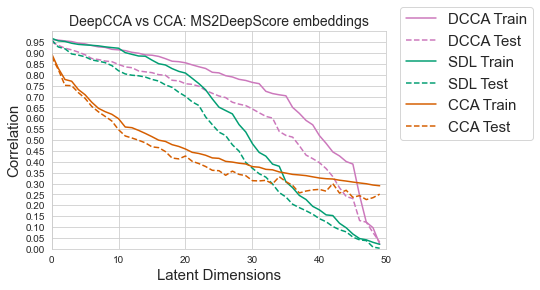

In [107]:
# plot train correlation vs test correlation
x=[x for x in range(latent_dims)]
fig, ax = plt.subplots()

sns.set_style('whitegrid')

line = ['solid', 'dashed']

#justice for the color blind :)
palette = [sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]] 

dfs = [[dcca_train_corr, dcca_test_corr],\
       [sdl_train_corr, sdl_test_corr],\
       [cca_train_corr,cca_test_corr]]

for i, df in enumerate(dfs):
    #train
    sns.lineplot(x=x,y=df[0], \
                 color = palette[i],
                 linestyle=line[0],ax=ax)
    #test
    sns.lineplot(x=x,y=df[1],\
                 color = palette[i],
                 linestyle=line[1], ax=ax)

    plt.legend(labels=['DCCA Train', 'DCCA Test',\
                  'SDL Train', 'SDL Test',\
                  'CCA Train', 'CCA Test'], \
                   loc=(1.04, 0.5),\
                    fontsize=15)#title='Algorithm', 
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1.0)
plt.title(label=f'DeepCCA vs CCA: {embedding} embeddings',\
          fontsize=14,loc='center')
plt.xlim(0, latent_dims)

plt.yticks(np.arange(0, 1, step=0.05))
plt.savefig(f'../plots/{method}_{data}_{dims}_vs_cca_{embedding}.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

### Assess Prediction Performance: DCCA

##### Predict Structure from spectra Embeddings

1. Calculate:

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [94]:
def predict(subject_df,query_df,metric='euc'): #both dfs should have z1 and z2 coloumns

    preds = {}

    for query_index in tqdm(query_df.index):
        
        query = query_df.loc[query_index,'z1'] #(query z1)
        preds[query_index] = []
        for subject_index in subject_df.index:
        
            subject = subject_df.loc[subject_index,'z2']#(subject z2)
            if metric == 'corr':
                corr = pearsonr(query[0:25], subject[0:25])[0]
                preds[query_index].append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[0:25], subject[0:25])
                preds[query_index].append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[0:25], subject[0:25])
                preds[query_index].append(cos)
    # you might want to sort preds and return only top hits for better memory
    return preds
    

In [36]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

In [37]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [70]:
def get_tanimotos(preditions_dict, metric):
    tanimotos = []
    for query_index, values in tqdm(preditions_dict.items()):
    
        #select top 5 hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:5]
        #select closest 5 hits for each query based on cosine/euclidian distance
        else:
            top_hits = np.sort(values)[:5]
    
        #calculate tanimoto scores for each of the top 5 hits
        top_hits_scores = []
        for hit in top_hits:
        
            subject_index = values.index(hit)
            smile1 = df_all.loc[subject_index,'smiles'] #extract the subject smile from the df before splitting
            smile2= df_all.loc[query_index,'smiles'] #extract the query smile from the df before splitting
            top_hits_scores.append(tanimoto(smile1,smile2))
        #select the max tanimoto score 
        tanimotos.append(max(top_hits_scores))
    return tanimotos
    

In [75]:
df_all.loc[24668,'spec_id']

'spec_id23005'

In [99]:
val_df.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,val_z1,z1,z2
774,C[C@]1([C@@H]2[C@@]3([C@@]([C@]([C@@H](C2)Cl)(...,LYCKQMCCONKVPQ-CXGOSFSJSA-N,LYCKQMCCONKVPQ,spec_id682,"[28.113309545497827, 4.7173699859522324, -63.7...","[0.0, 0.0, 12.8699951171875, 11.31245803833007...","[-2.7817805, -4.838593, -4.7034383, 0.872167, ...",Indoles and derivatives,"[-0.043691456, 0.15210444, 0.05618699, -0.1609...","[-0.043691456, 0.15210444, 0.05618699, -0.1609...","[0.15582094, 0.036327243, -0.2023071, 0.009564..."
19512,CCOc1ccccc1C1C2CCCCC2(O)CCN1C(=O)c1cc(OCC)c(OC...,BIWBWLXLEJJNPK-UHFFFAOYSA-N,BIWBWLXLEJJNPK,spec_id17460,"[8.34956796264629, -8.237652862874603, -7.9721...","[0.0, 0.0, 5.87375020980835, 0.0, 0.0, 9.04621...","[1.536869, -3.6889842, -3.3219972, 6.929264, 2...",Isoquinolines and derivatives,"[0.08280762, 0.12272018, 0.088173546, -0.10229...","[0.08280762, 0.12272018, 0.088173546, -0.10229...","[0.08758394, 0.045104653, -0.16433392, 0.00359..."
29307,CCS(=O)(=O)c1cccnc1S(=O)(=O)NC(=O)Nc1nc(OC)cc(...,MEFOUWRMVYJCQC-UHFFFAOYSA-N,MEFOUWRMVYJCQC,spec_id27933,"[-2.466023647412307, -8.252851771420175, -10.0...","[5.632078170776367, 20.117168426513672, 0.0, 0...","[2.0711641, -5.9037433, -1.9117578, 5.9813676,...",Pyridines and derivatives,"[0.036005024, -0.044293053, 0.028039834, -0.07...","[0.036005024, -0.044293053, 0.028039834, -0.07...","[0.103625394, -0.000867486, -0.11690119, -0.00..."
29685,COc(c3)c(OC)c(c(=O)1)c(c3)c(=O)c(o2)c(cc2)1,VMGYORRTCREVTB-UHFFFAOYSA-N,VMGYORRTCREVTB,spec_id28305,"[-6.561650636844693, 18.69227770926524, -0.077...","[0.0, 0.0, 17.358600616455078, 0.0, 0.0, 23.64...","[0.7417944, -2.2236245, -3.3814728, 3.0209122,...",Naphthofurans,"[0.073036075, -0.033899054, 0.061936785, -0.05...","[0.073036075, -0.033899054, 0.061936785, -0.05...","[0.09063153, 0.02821906, -0.09950213, 0.020109..."
36621,COc1c(C)c2c(c(O)c1C/C=C(\C)C(O)CC(=O)O)C(=O)OC2,OGJCZLOIKMTMKF-XBXARRHUSA-N,OGJCZLOIKMTMKF,spec_id35998,"[-18.146954495255013, 36.09209987288244, -37.6...","[0.0, 0.0, 0.0, 1.4671721458435059, 0.0, 45.45...","[0.046677783, -0.8537935, -5.358523, 0.0829242...",Isocoumarans,"[0.06389905, 0.1663808, 0.09955686, -0.0694454...","[0.06389905, 0.1663808, 0.09955686, -0.0694454...","[0.10652392, 0.033280715, -0.14532009, 0.05243..."


In [ ]:
%%time
#predict euc
val_dcca_euc = predict(subject_df=train_df,query_df=val_df, metric='euc')

 21%|████████████████▌                                                              | 252/1203 [01:26<05:33,  2.85it/s]

In [98]:
for key, score in val_dcca_euc.items():
    print(key)

12710
24668
29313
21974
16187
35076
34322
12962
35103
4284
15534
23243
26592
10464
38575
35780
3951
36505
30396
29501
14422
29713
16146
32889
39363
4022
25969
28033
20577
9149
8212
31774
29179
21379
34545
40180
9450
9535
12317
16000
6940
16653
451
36862
17724
28261
13581
27110
22751
10971
31580
18662
17905
23271
33718
13692
25495
1589
19788
7347
23372
11502
5998
40325
11599
35058
23305
23182
10393
14779
38766
10116
19068
38958
21431
13744
7725
38334
40448
29907
2385
39307
36492
6622
40222
29169
5321
17371
36199
5383
29021
24404
8286
111
38845
11492
33442
20055
39485
11351
28219
12354
28843
26304
2989
17625
36997
7861
10632
20692
13988
4578
23718
1317
28887
19935
33956
40457
27029
27872
23291
39393
11263
28985
4148
9418
32347
25207
33800
34661
19538
12706
25404
37115
3231
23543
30862
38647
22262
13885
33445
28682
25650
40218
35174
7240
2145
31120
40961
22052
17582
33382
36591
23000
25751
37410
30529
9314
6639
29120
37836
11327
36224
8547
32990
28484
11551
17441
24353
30606
6460
40722
29

12203
9772
27564
24165
10433
14386
4274
13210
1971
33912
7829
26928
38918
23460
17555
50
6868
776
22137
32741
13975
4879
31459
10218
18575
16117
17674
3419
26718
18235
22705
13647
24518
28752
25347
21580
33017
7694
16135
10869
28754
39388
19223
35391
35466
10796
10148
10673
31907
22144
7989
28021
18008
34522
29264
29132
31088
16332
5935
38873
16526
14961
11242
16513
23074
31190
26571
24888
13061
15073
20640
35887
38199
15271
428
14653
14649
41402
28198
3570
4878
40691
7533
31825
34233
2795
15959
39049
10699
24362
21278
3652
36036
12957
19278
36259
4895
7382
21808
38950
7736
24303
25137
11333
10178
11127
15482
34038
27253
31332
35711
5296
28620
36569
14001
31388
40625
41047
27411
26062
19528
25010
22289
16361
6899
39706
4922
30154
9997
9608
34991
22115
29130
13860
7485
19231
32430
18252
27695
36229
13308
3036
20772
25897
39908
6796
29216
19557
19948
13851
38180
9132
7436
16109
19954
4796
26538
10406
39021
2842
4367
24541
14768
21970
28213
1583
36227
12486
41091
16011
12510
38457
18707
9

40150
9489
38976
5685
12554
17290
9744
12179
4136
5054
8015
37614
8592
27789
9369
34285
23212
11166
18732
38464
30843
36114
8685
26548
40091
23783
18540
24763
32104
5969
39635
18583
4843
8076
16242
31489
11494
18646
30420
19794
39210
27051
20807
40025
24757
3716
8110
23015
985
7293
5387
18754
2856
16691
1701
1094
8269
2578
25914
7138
19205
40538
19480
9228
36083
37074
2028
40510
21366
35032
21766
22614
31313
11836
34115
23834
16576
13910
14448
17632
7000
25883
118
1802
23199
2747
8107
1538
40525
15574
36768
13141
13317
9271
30723
37555
2269
18153
24482
6193
32224
480
25261
11308
17160
4563
8788
30218
783
21986
19767
36987
31696
35260
1495
11598
14123
22492
25635
12500
23276
32626
30961
22932
608
2907
14943
17072
7894
22268
39645
18133
27677
21695
23348
34012
4413
22969
32919
22451
150
30899
1525
10246
19743
246
209
23310
6402
9317
33347
1889
7119
1724
30552
41252
8507
8486
23323
41178
2885
9295
19219
38520
11500
16144
31950
14203
14550
13648
26841
13680
33231
36637
19262
32
30655
27410

6018
2960
17448
592
18196
6246
24588
37558
14533
8509
34134
38496
7275
10983
30214
6354
14991
36435
10897
25190
1974
26997
4751
25536
35985
17567
20131
23699
367
18110
29458
6991
18460
20387
486
22241
1857
20691
27193
32641
35613
31469
20363
31232
36296
37750
32366
29521
16386
6929
2371
5786
28608
36996
7379
28354
17389
30791
8620
33004
13998
7779
36933
30999
8336
13868
12530
27802
13465
21682
19000
6939
15624
30765
26673
6786
252
38507
10566
6165
3184
41378
9582
40387
12602
22545
8145
20736
9401
3324
8180
31111
24082
2908
39407
10359
20524
36030
12306
4985
9738
32873
34827
33626
3038
10185
39880
19200
5362
15135
5259
35966
11406
10601
1510
7815
16226
23067
18411
9690
12646
36784
19201
35127
37023
38441
250
26581
35107
24506
36767
29847
15479
9296
21050
5338
27174
1858
5512
11765
20416
40894
35424
18135
30790
17040
6009
17985
6122
15067
25873
17588
30434
19030
30430
956
32684
28553
6830
17529
2214
20803
16480
28108
32282
13411
6566
39317
23377
38081
31873
16658
15612
12711
32047
9705
1

37595
36143
11604
18919
15470
4952
4739
31097
35835
11008
22271
25055
27156
24088
22915
3242
26744
21409
24792
32499
25932
30949
28368
32481
3338
27005
6384
25853
9266
19754
32561
39773
41438
12531
37652
36891
8874
28721
19719
24873
29328
22055
343
12778
3828
33664
8290
31311
1332
30114
2367
26405
29689
26179
6089
26366
23722
9819
26290
21879
7771
8771
4070
20168
30787
2387
400
25505
15302
8748
27275
36
9292
19927
3520
33809
23417
38149
35303
26380
15252
32102
9457
8457
38347
39781
37300
13009
34648
24486
40602
4604
34949
31170
24874
2514
19482
36023
29568
4780
24813
7231
529
5897
6734
24876
31352
10062
12831
11320
34306
34817
34698
6041
3585
31133
16652
32301
32352
39950
9844
22466
13853
37899
39789
23435
36509
18940
32513
25059
31476
34959
22742
6654
36594
21127
39828
8698
41316
17635
34271
40613
781
21669
39240
33286
8256
27660
38451
5095
8387
19516
23605
15380
3560
41052
22511
3788
122
7270
9587
18802
24006
30464
19104
16531
26790
29535
18884
13764
6271
12136
6841
22538
29361
29852

12462
1477
11462
3566
35856
14790
16616
29639
1287
17004
17283
25375
30478
4053
41204
38297
5625
29193
27060
4412
30987
6034
34757
15158
34520
37619
38988
9068
36978
16311
14721
5703
40487
12759
16095
12982
32769
14451
3662
18051
8641
22703
19680
849
19171
13517
5319
23739
14973
20321
37439
9482
39922
21559
24596
28437
40731
12740
29579
13751
40954
39305
35746
38986
9038
32627
12943
14970
27421
25608
14903
36714
30500
33750
13052
38883
41012
10060
20318
38461
26536
10957
14377
21233
2173
15369
40603
35667
13383
22131
7108
35007
15640
18821
11523
3778
10529
5839
2304
38251
32365
3200
34595
8659
27640
23960
39859
26170
36785
19640
34713
6422
32266
13756
13135
26843
25266
10998
4195
33428
39739
24986
40360
17346
11854
29387
8976
11108
17577
33961
30058
1219
39538
20644
31730
39895
32195
25229
4618
1999
18432
13640
21062
32333
7527
28458
5167
7975
2697
35387
327
25043
25336
1908
34428
17383
1555
25990
3868
586
36854
27321
28409
40339
34597
34424
14598
32252
5914
36990
2123
24933
9246
36478

558
8373
4266
31871
16761
38063
33804
34237
19021
11810
21276
18121
35677
35239
28857
738
3712
33880
17320
24612
5559
2136
24940
6595
23977
5275
39099
27429
18453
17608
41274
39276
4554
13291
9911
24787
11158
24574
17676
17821
4182
38952
29627
7348
3705
40181
12941
17712
413
11356
23954
24481
33151
33933
6008
12336
8210
27737
28770
39666
12769
33375
17895
3584
41281
19214
2334
2243
8921
20702
25603
38833
11543
37172
6445
37979
25749
18982
22203
3942
11159
28917
29821
15190
20155
37035
14590
4939
3375
36064
16044
9945
17179
9445
12247
12467
8564
11480
10135
35917
5932
21582
39967
29550
35302
7150
8109
31144
24305
16685
38819
6408
14213
19814
9878
35301
33402
29832
27079
27442
19685
39797
21637
17303
21124
32402
10152
833
35762
16048
24040
38235
4255
35774
22285
2283
12533
19677
29024
13503
29161
18149
37446
34429
12059
30126
39638
1953
24398
13355
12212
17969
4935
623
20507
28089
417
5513
7698
19885
5567
26544
36004
28969
35146
3015
20695
36002
24657
25443
7511
4358
21200
13778
37930
22

6993
10895
23266
32097
34375
41382
31890
26714
22721
24693
24631
18159
3984
30437
16147
9693
10674
30015
6610
8298
21798
12852
4265
4458
8436
15347
23471
12370
15985
3784
36650
37929
24697
35419
29352
23785
6852
38528
27035
24123
28963
29716
33872
3726
32087
13779
28364
36708
7152
21503
16110
22912
14731
2213
3906
35463
28536
24623
29452
24557
24726
18006
33970
30740
37575
9659
40505
17748
2452
38399
13919
19807
5675
29764
18111
37163
1028
21234
22845
22708
33876
31783
22673
5116
11039
10006
13008
37831
37390
2391
22675
37996
17089
11830
28579
29198
21210
38715
18899
25109
11889
23229
11578
16552
18665
15646
34122
24872
1641
11237
12249
7882
24191
38391
23295
29114
8971
9845
12914
39798
35999
17633
39152
19533
31487
31935
36270
29300
20774
21825
8337
24389
861
32721
21480
37395
27237
11340
3429
35950
22765
8440
32234
1895
2050
1108
13912
34567
26208
10919
16070
10278
13082
4877
7318
22207
18278
10252
39221
6053
11260
38708
11794
30377
36408
33456
1563
32044
2185
38308
20135
14357
40154

38667
13773
13333
13496
29882
12643
28095
14066
23425
15171
3243
4685
5873
31778
34064
39653
5359
23143
9877
24038
37966
6690
16327
18401
11679
37920
17761
7918
32998
33966
21015
23516
6978
16429
8119
18450
8683
29675
38919
1886
26869
13354
12837
11602
7016
22659
8235
17158
32547
41067
18551
16273
10243
34338
8195
36658
10374
33944
39038
21944
29964
24097
7103
2142
9576
39843
845
8325
26674
19117
28611
20444
7218
29763
26816
29288
3463
10635
1605
40317
7319
30230
30424
41243
13923
7197
40400
21182
25987
13293
16446
8185
28605
24809
32490
17593
5344
9151
2695
23056
41388
14711
33661
76
22746
21226
1728
4544
4482
8004
22540
24248
5843
40108
37331
20062
16215
26545
38880
7200
3533
841
30592
1494
34924
15527
2952
20624
38079
40607
24102
21846
30083
19281
11916
41095
11915
20219
4648
32495
30557
35179
15468
28636
28146
25512
21874
29111
2342
19444
32923
8757
29231
16153
29430
6827
20249
28221
8680
14006
17808
98
4181
6874
38822
22452
528
5979
34119
32064
22187
40706
32091
29136
13315
14352


In [50]:
type(dcca_val_df)

pandas.core.frame.DataFrame

In [96]:
%%time
#calculate Euclidean tanimotos 
    
    
val_dcca_euc_tanimotos = get_tanimotos(val_dcca_euc, 'euc')

  0%|                                                                               | 20/28066 [00:00<10:08, 46.08it/s]


KeyError: 340

In [51]:
type(val_dcca_euc)

dict

In [ ]:
ax=sns.kdeplot(x=dist,shade=False)

#### Draw Random predicted molecule

In [13]:
from rdkit import Chem
from rdkit.Chem import Draw

In [27]:
import random
keys = random.sample(ms2ds_preds_euc.keys(),5)
sample_dict = {key: ms2ds_preds_euc[key] for key in keys}

C:\Users\lmeli\AppData\Local\Temp/ipykernel_11028/3792517325.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(ms2ds_preds_euc.keys(),5)


In [ ]:
#function to draw structuctures

scores = []
os.chdir('../compounds')
for query_index, values in tqdm(sample_dict.items()):
    top_hits = np.sort(values)[:5]
    tanimotos = []
    #draw the query
    query_smile= test_df['smiles'].iloc[query_index]
    query_class = test_df['cf_class'].iloc[query_index]
    query = Chem.MolFromSmiles(query_smile)
    Draw.MolToFile(query, f"query_{query_index}_{query_class}.png")
    #draw top 5 hits
    for hit_index, hit in enumerate(top_hits):
        subject_index = values.index(hit)
        subject_smile = train_df['smiles'].iloc[subject_index]
        subject_class = train_df['cf_class'].iloc[subject_index]
        
        subject = Chem.MolFromSmiles(subject_smile)
        Draw.MolToFile(subject, f"query_{query_index}_hit_{hit_index}_{subject_class}.png")
        if query_index == 6679 or 4255:
        #calculate tanimotos for the sampled query and subject
            tanimotos.append(tanimoto(query_smile,subject_smile))
    scores.append([(query_index),tanimotos])
        
        
os.chdir('../raw_data')        

In [ ]:
rdkit.Chem.Draw.ShowMol